In [493]:
import os
import re
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import skimage
import anndata as ad
import seaborn as sns
from matplotlib.pyplot import rc_context
from tqdm.notebook import tqdm, trange

sc.settings.verbosity = 3

In [494]:
p_dir = (Path().cwd().parents[0]).absolute()
data_dir = p_dir / "data"

In [495]:
%load_ext autoreload
%autoreload 2

module_path = str(p_dir / "src")

if module_path not in sys.path:
    sys.path.append(module_path)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [496]:
import scSpaMet as spamet

In [497]:
experiment = "lung"
cores = ["B5", "C6", "D4", "E4", "E6", "F4", "F7"]
datasets = [core + f"_{i}" for i in range(1, 5) for core in cores]

In [498]:
# experiment = "tonsil"
# cores = ["DonorA", "DonorE"]
# datasets = [core + f"_{i}" for i in range(1, 7) for core in cores]

# Load data

In [499]:
def read_props(dataset):
    df_morph = pd.read_csv(data_dir / "props" / f"morphology_IMC_{dataset}.csv")
    df_intensity_IMC = pd.read_csv(data_dir / "props" / f"intensity_IMC_{dataset}.csv")
    df_intensity_TS = pd.read_csv(data_dir / "props" / f"intensity_TS_{dataset}.csv")

    return df_morph, df_intensity_IMC, df_intensity_TS

In [507]:
for dataset in datasets:
    try:
        df_morph, df_intensity_IMC, df_intensity_TS = read_props(
            "_".join([experiment, dataset])
        )
    except:
        continue
    break
    
# Define IMC and SIMS marker list
IMC_markers = df_intensity_IMC.columns.tolist()[1:]
SIMS_masses = df_intensity_TS.columns.tolist()[1:-2]

# Drop markers
drop_list = ['MHCII', "CD11b", "DNA1", "DNA2", "HistoneH3", 'CD83', 'CD86', 'CXCR4', 'CD138', 'CD45RA', 'CD45RO']
# drop_list = ['MHCII', "CD11b", "CD11c", "DNA1", "DNA2", "HistoneH3", 'CD83', 'CD86', 'CXCR4']
IMC_markers = [m for m in IMC_markers if m not in drop_list]

In [508]:
# Load data
path = data_dir / 'joint' / f'{experiment}.h5ad' 
adata = ad.read_h5ad(path)

C:\Users\thu71\Anaconda3\envs\new_codex\lib\site-packages\anndata\_core\anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


# VIz

## IMC heatmap

In [509]:
sc.tl.leiden(adata, resolution=0.25, random_state=0)

running Leiden clustering
    finished: found 8 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:01)


In [510]:
adata_IMC = adata[:, IMC_markers]
sc.pp.scale(adata_IMC, max_value=4)

C:\Users\thu71\Anaconda3\envs\new_codex\lib\site-packages\scanpy\preprocessing\_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
C:\Users\thu71\Anaconda3\envs\new_codex\lib\site-packages\scanpy\preprocessing\_simple.py:843: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  view_to_actual(adata)


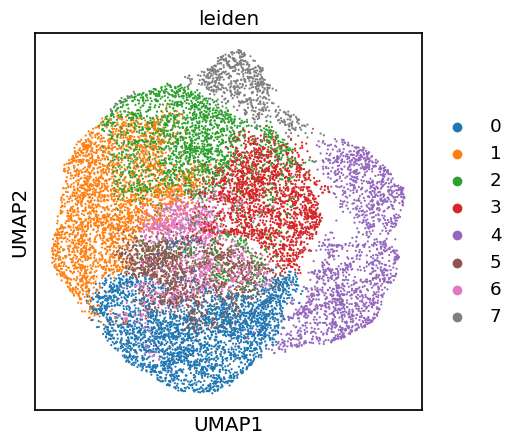

In [511]:

with rc_context({"figure.figsize": (5, 5), "figure.dpi": 100}):
    fig = sc.pl.umap(adata_IMC, color=["leiden"], size=10)

    using data matrix X directly
Storing dendrogram info using `.uns['dendrogram_leiden']`


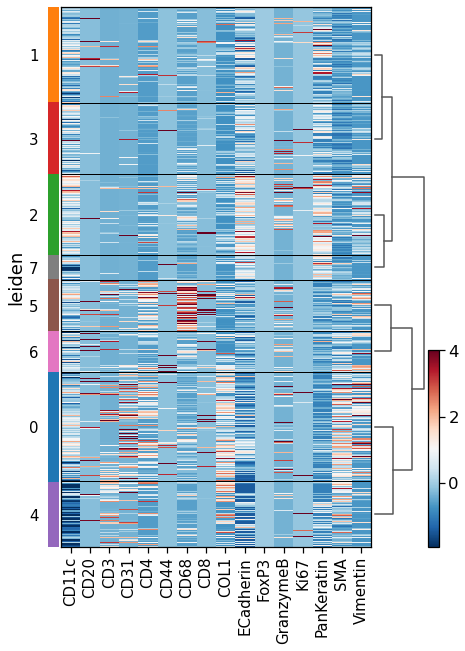

In [512]:
sns.set_context("notebook", font_scale=1.5)

sc.pl.heatmap(
    adata_IMC,
    adata_IMC.var_names.tolist(),
    "leiden",
    dendrogram=True,
    cmap="RdBu_r",
    figsize=(7, 10),
)

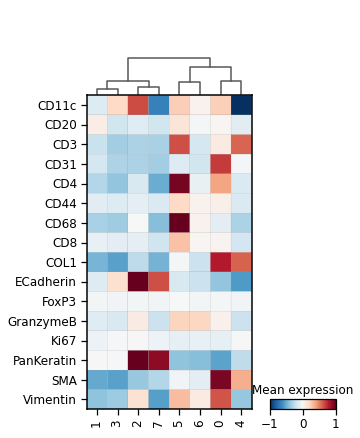

In [513]:
sns.set_context("notebook", font_scale=1.2)

sc.pl.matrixplot(
    adata_IMC,
    adata_IMC.var_names.tolist(),
    "leiden",
    dendrogram=True,
    colorbar_title="Mean expression",
    cmap="RdBu_r", 
    swap_axes=True,
    vmin=-1,
    vmax=1
)

## IMC cell mask

In [514]:
import matplotlib
import skimage

# Read mask image
def get_masks(mask_folder):
    """
    Function to get all mask from mask forlder
    """
    # Read masks
    masks = {}

    for (dirpath, dirnames, filenames) in os.walk(mask_folder):
        for name in sorted(filenames):
            if "tif" in name:
                filename = os.path.join(dirpath, name)
                img = skimage.io.imread(filename)
                condition = name.split(".")[0]
                masks[condition] = img
            else:
                continue
    return masks


def create_clustered_cell(mask, label2cell, my_cmap, **kwargs):
    img = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)

    for i, cells in tqdm(label2cell.items(), total=len(label2cell)):
        rows, cols = np.where(np.isin(mask, cells))
        if type(my_cmap) is np.ndarray:
            img[rows, cols, :] = my_cmap[int(i)]
        else:
            img[rows, cols, :] = my_cmap[i]

    return img

In [226]:
masks = get_masks(data_dir / "masks")

In [227]:
colors = adata_IMC.uns["leiden_colors"]
labels = np.unique(adata_IMC.obs.leiden.tolist())

colors_rgb = []
for color in colors:
    colors_rgb.append(matplotlib.colors.hex2color(color))
colors_rgb = np.array(colors_rgb) * 255
colors_rgb = colors_rgb.astype(np.uint8)

B5_1


  0%|          | 0/14 [00:00<?, ?it/s]

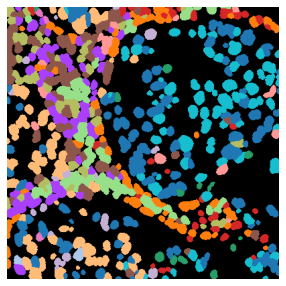

C6_1


  0%|          | 0/14 [00:00<?, ?it/s]

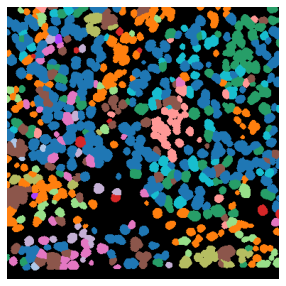

D4_1


  0%|          | 0/14 [00:00<?, ?it/s]

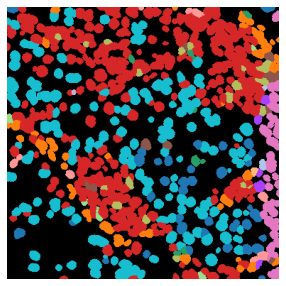

E4_1


  0%|          | 0/14 [00:00<?, ?it/s]

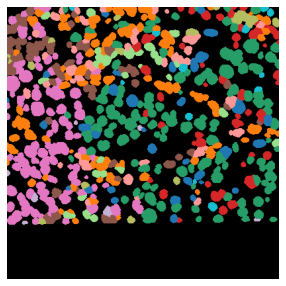

E6_1


  0%|          | 0/14 [00:00<?, ?it/s]

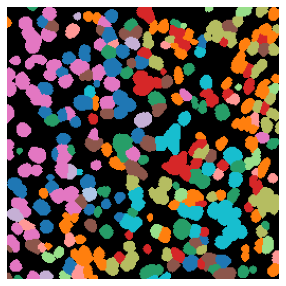

F4_1


  0%|          | 0/14 [00:00<?, ?it/s]

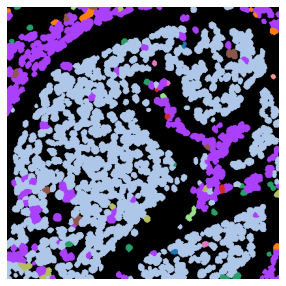

F7_1


  0%|          | 0/14 [00:00<?, ?it/s]

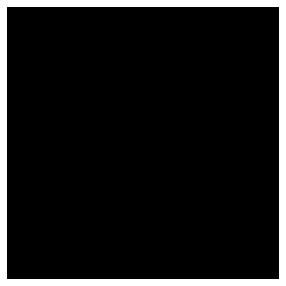

B5_2


  0%|          | 0/14 [00:00<?, ?it/s]

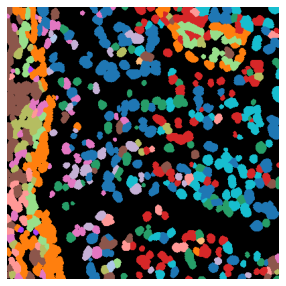

C6_2


  0%|          | 0/14 [00:00<?, ?it/s]

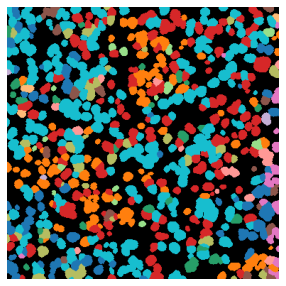

D4_2


  0%|          | 0/14 [00:00<?, ?it/s]

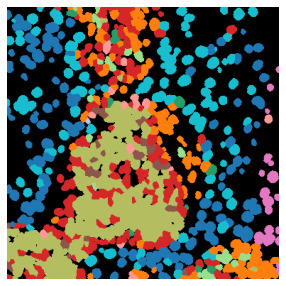

E4_2


  0%|          | 0/14 [00:00<?, ?it/s]

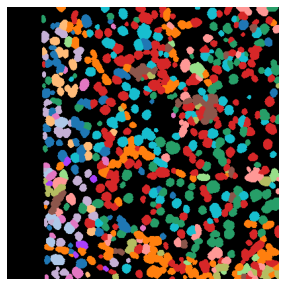

E6_2


  0%|          | 0/14 [00:00<?, ?it/s]

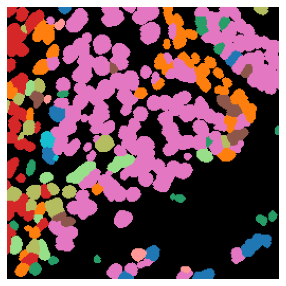

F4_2


  0%|          | 0/14 [00:00<?, ?it/s]

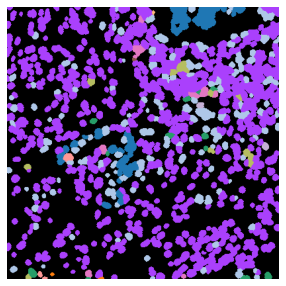

F7_2


  0%|          | 0/14 [00:00<?, ?it/s]

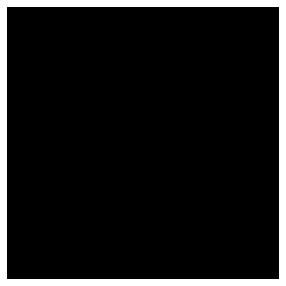

B5_3


  0%|          | 0/14 [00:00<?, ?it/s]

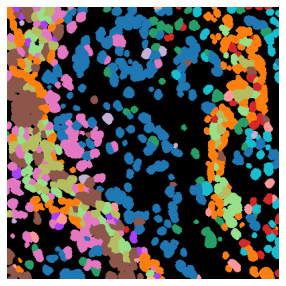

C6_3


  0%|          | 0/14 [00:00<?, ?it/s]

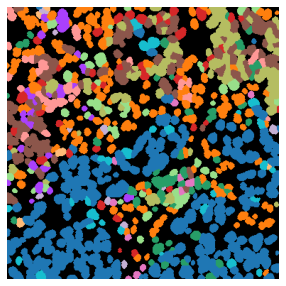

D4_3


  0%|          | 0/14 [00:00<?, ?it/s]

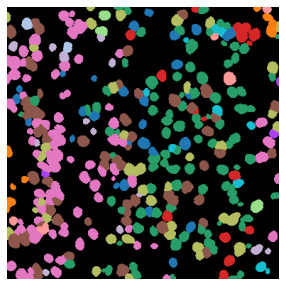

E4_3


  0%|          | 0/14 [00:00<?, ?it/s]

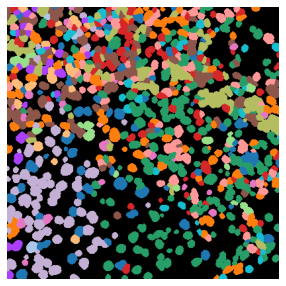

E6_3


  0%|          | 0/14 [00:00<?, ?it/s]

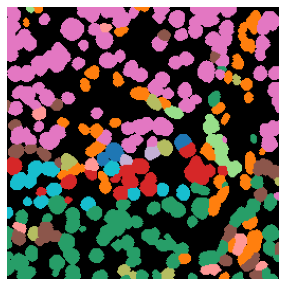

F4_3


  0%|          | 0/14 [00:00<?, ?it/s]

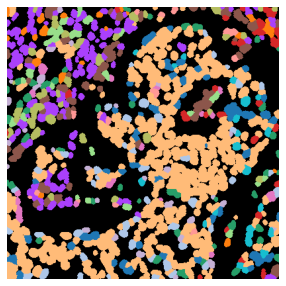

F7_3


  0%|          | 0/14 [00:00<?, ?it/s]

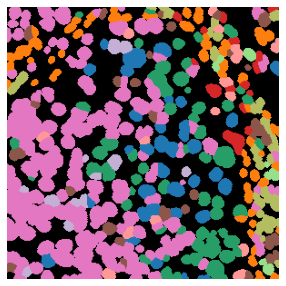

B5_4
C6_4


  0%|          | 0/14 [00:00<?, ?it/s]

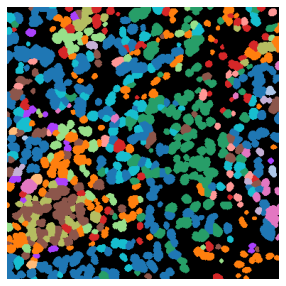

D4_4
E4_4


  0%|          | 0/14 [00:00<?, ?it/s]

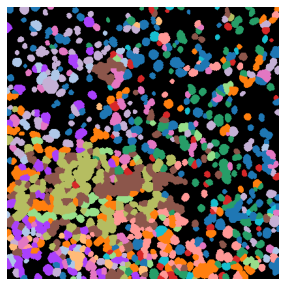

E6_4
F4_4
F7_4


  0%|          | 0/14 [00:00<?, ?it/s]

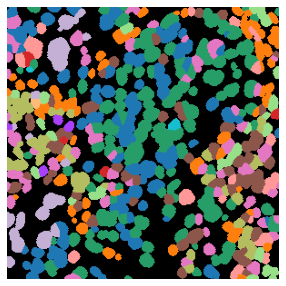

In [228]:
experiment = 'Lung'

for dataset in datasets:
    print(dataset)
    try:
        adata_subset = adata_IMC[adata_IMC.obs.Dataset == dataset, :]
        mask = masks[experiment + '_' + dataset]

        # Get label2cell dict
        label2cell = {}
        for l in labels:
            cell_id = adata_subset[adata_subset.obs.leiden == l].obs.Cell.to_list()
            label2cell[l] = cell_id

        img = create_clustered_cell(mask, label2cell, colors_rgb)

        fig, ax = plt.subplots(figsize=(5, 5))
        ax.imshow(img)
        ax.axis("off")
        plt.show()
    except:
        pass

# Define type

In [529]:
type_dict = {'0': 'Stroma',
            '1': 'Epithelial-1',
            '2': 'Epithelial-2', 
            '3': 'Epithelial-1',
            '4': 'Stroma',
             '5': 'CD68',
             '6': 'Other',
             '7':  'Epithelial-2',
            }

In [530]:
adata_IMC

AnnData object with n_obs × n_vars = 14879 × 16
    obs: 'Cell', 'Dataset', 'Core', 'leiden', 'Type'
    var: 'mean', 'std'
    uns: 'Dataset_colors', 'leiden', 'neighbors', 'umap', 'leiden_colors', 'dendrogram_leiden', 'Type_colors'
    obsm: 'Joint', 'X_umap', 'spatial'
    obsp: 'connectivities', 'distances'

In [531]:
adata_IMC.obs['Type'] = (
    adata_IMC.obs['leiden']
    .map(type_dict)
    .astype("category")
)
type_list = adata_IMC.obs['Type']
type_list = np.where(np.array(adata_IMC[:, 'CD8'].X.flatten()) > 2, 'CD8+', type_list)
# type_list = np.where(np.array(adata_IMC[:, 'CD20'].X.flatten()) > 2, 'CD20+', type_list)
# type_list = np.where(np.array(adata_IMC[:, 'CD4'].X.flatten()) > 2, 'CD4+', type_list)
# type_list = np.where(np.array(adata_IMC[:, 'CD3'].X.flatten()) > 2, 'CD3+', type_list)
adata_IMC.obs['Type'] = type_list
adata_IMC.obs['Type'] = adata_IMC.obs['Type'].astype("category")

adata_IMC.uns['Type_colors'] = adata_IMC.uns['leiden_colors'][:len(np.unique(adata_IMC.obs['Type']))]

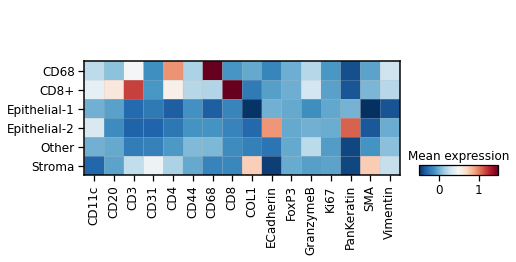

In [532]:
sns.set_context("notebook", font_scale=1.2)

sc.pl.matrixplot(
    adata_IMC,
    adata_IMC.var_names.tolist(),
    "Type",
    dendrogram=False,
    colorbar_title="Mean expression",
    cmap="RdBu_r", 
    vmax=1.5
)

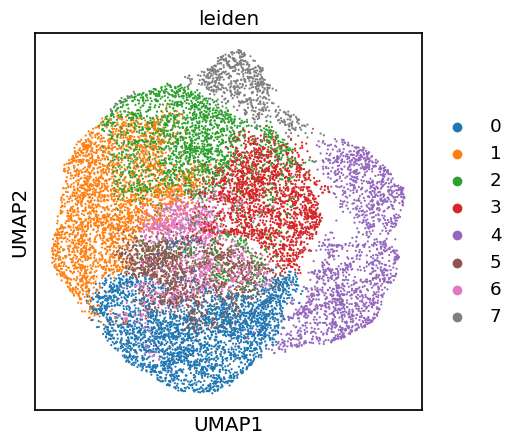

In [533]:

with rc_context({"figure.figsize": (5, 5), "figure.dpi": 100}):
    fig = sc.pl.umap(adata_IMC, color=["leiden"], size=10)

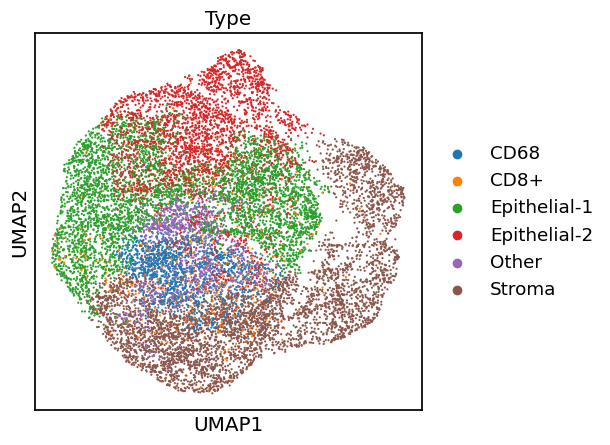

In [534]:

with rc_context({"figure.figsize": (5, 5), "figure.dpi": 100}):
    fig = sc.pl.umap(adata_IMC, color=["Type"], size=10)

In [535]:
colors = adata_IMC.uns["Type_colors"]
labels = adata_IMC.obs.Type.cat.categories.tolist()

colors_rgb = []
for color in colors:
    colors_rgb.append(matplotlib.colors.hex2color(color))
colors_rgb = np.array(colors_rgb) * 255
colors_rgb = colors_rgb.astype(np.uint8)

colors_rgb_dict = {k:v for k,v in zip(labels, colors_rgb)}

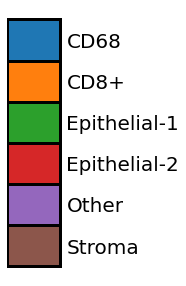

In [536]:
# legend
fig, ax = plt.subplots(figsize=(1,5))
ax.barh(y=range(len(colors_rgb_dict.values())), 
        color=np.array(list(colors_rgb_dict.values()))/255,
        width=1, 
        height=1,
        edgecolor='k',
        linewidth=3,
       )
_ = plt.yticks(range(len(colors_rgb_dict.values())), colors_rgb_dict.keys(), rotation=0, size=20)
_ = plt.xticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(axis=u'both', which=u'both',length=0)
ax.yaxis.tick_right()
ax.invert_yaxis()

B5_1


  0%|          | 0/6 [00:00<?, ?it/s]

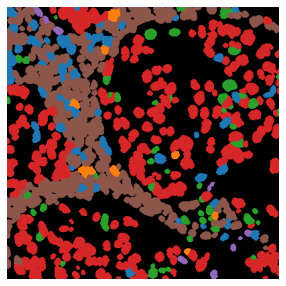

C6_1


  0%|          | 0/6 [00:00<?, ?it/s]

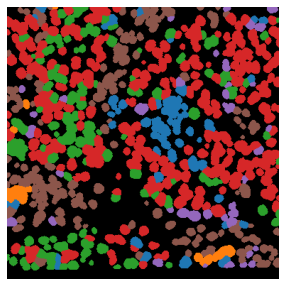

D4_1


  0%|          | 0/6 [00:00<?, ?it/s]

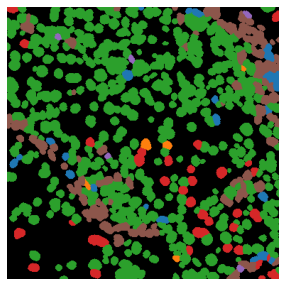

E4_1


  0%|          | 0/6 [00:00<?, ?it/s]

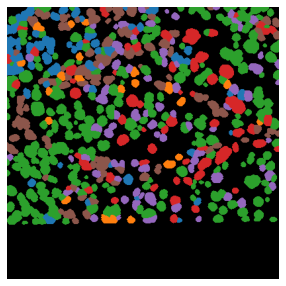

E6_1


  0%|          | 0/6 [00:00<?, ?it/s]

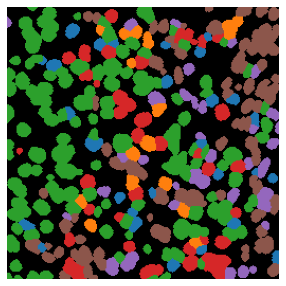

F4_1


  0%|          | 0/6 [00:00<?, ?it/s]

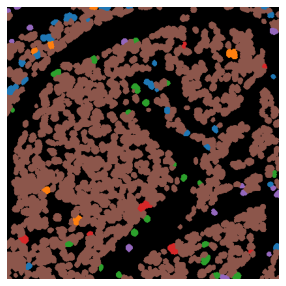

F7_1


  0%|          | 0/6 [00:00<?, ?it/s]

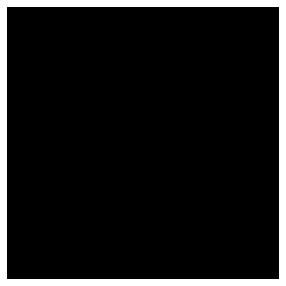

B5_2


  0%|          | 0/6 [00:00<?, ?it/s]

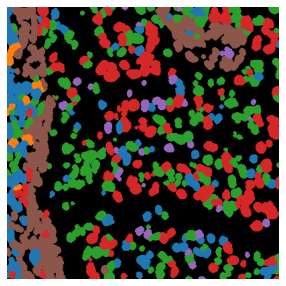

C6_2


  0%|          | 0/6 [00:00<?, ?it/s]

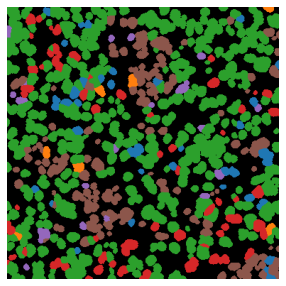

D4_2


  0%|          | 0/6 [00:00<?, ?it/s]

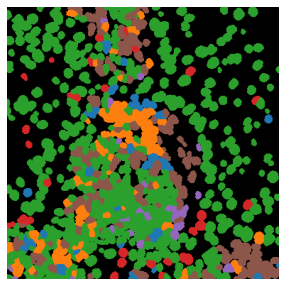

E4_2


  0%|          | 0/6 [00:00<?, ?it/s]

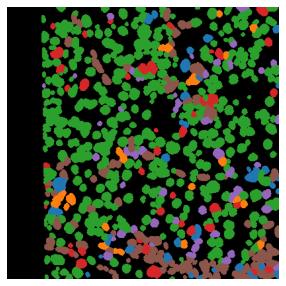

E6_2


  0%|          | 0/6 [00:00<?, ?it/s]

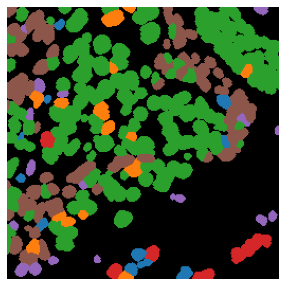

F4_2


  0%|          | 0/6 [00:00<?, ?it/s]

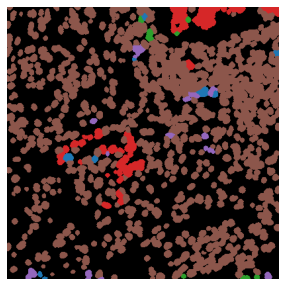

F7_2


  0%|          | 0/6 [00:00<?, ?it/s]

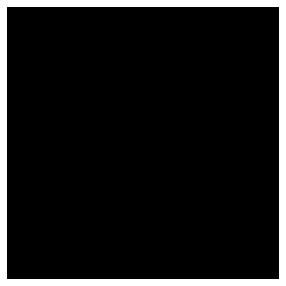

B5_3


  0%|          | 0/6 [00:00<?, ?it/s]

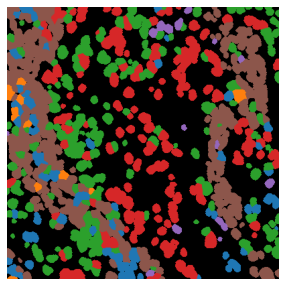

C6_3


  0%|          | 0/6 [00:00<?, ?it/s]

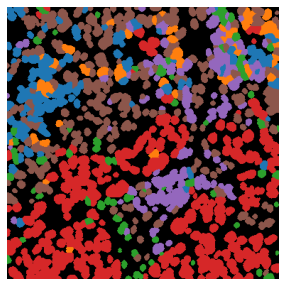

D4_3


  0%|          | 0/6 [00:00<?, ?it/s]

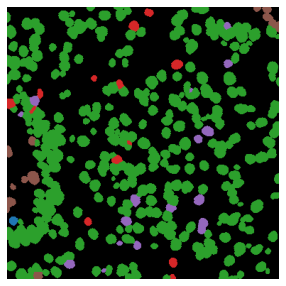

E4_3


  0%|          | 0/6 [00:00<?, ?it/s]

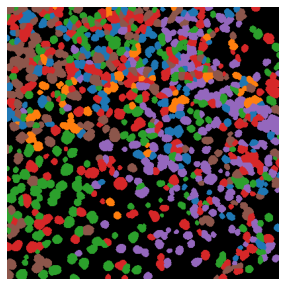

E6_3


  0%|          | 0/6 [00:00<?, ?it/s]

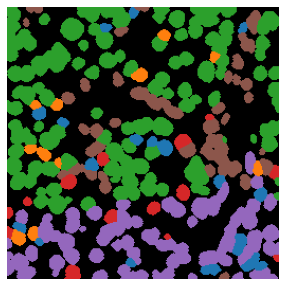

F4_3


  0%|          | 0/6 [00:00<?, ?it/s]

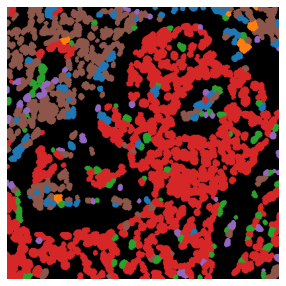

F7_3


  0%|          | 0/6 [00:00<?, ?it/s]

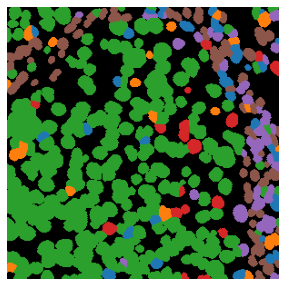

B5_4
C6_4


  0%|          | 0/6 [00:00<?, ?it/s]

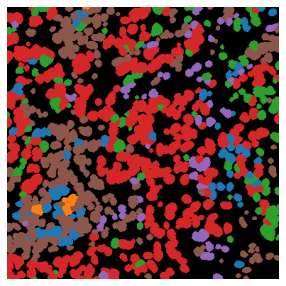

D4_4
E4_4


  0%|          | 0/6 [00:00<?, ?it/s]

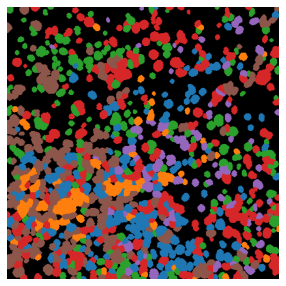

E6_4
F4_4
F7_4


  0%|          | 0/6 [00:00<?, ?it/s]

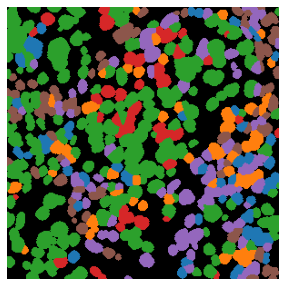

In [537]:
experiment = 'Lung'

for dataset in datasets:
    print(dataset)
    try:
        adata_subset = adata_IMC[adata_IMC.obs.Dataset == dataset, :]
        mask = masks[experiment + '_' + dataset]

        # Get label2cell dict
        label2cell = {}
        for l in labels:
            cell_id = adata_subset[adata_subset.obs.Type == l].obs.Cell.to_list()
            label2cell[l] = cell_id

        img = create_clustered_cell(mask, label2cell, colors_rgb_dict)

        fig, ax = plt.subplots(figsize=(5, 5))
        ax.imshow(img)
        ax.axis("off")
        plt.show()
    except:
        pass

# SIMS 

In [538]:
# adata_IMC.obs['Type'] = adata_IMC.obs['leiden']
# adata_IMC.uns['Type_colors'] = adata_IMC.uns['leiden_colors'][:len(np.unique(adata_IMC.obs['Type']))]

In [539]:
sns.set_context("talk", font_scale=1.1)

adata_SIMS = adata[:, SIMS_masses[1:]]
adata_SIMS.obs['Type'] = adata_IMC.obs['Type']

C:\Users\thu71\AppData\Local\Temp/ipykernel_9472/456081054.py:4: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_SIMS.obs['Type'] = adata_IMC.obs['Type']
C:\Users\thu71\Anaconda3\envs\new_codex\lib\site-packages\anndata\_core\anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
C:\Users\thu71\Anaconda3\envs\new_codex\lib\contextlib.py:126: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  next(self.gen)


In [540]:
sc.tl.rank_genes_groups(adata_SIMS, groupby='Type',method='t-test')


ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


         Falling back to preprocessing with `sc.pp.pca` and default params.
computing PCA
    with n_comps=50
    finished (0:00:00)
Storing dendrogram info using `.uns['dendrogram_Type']`


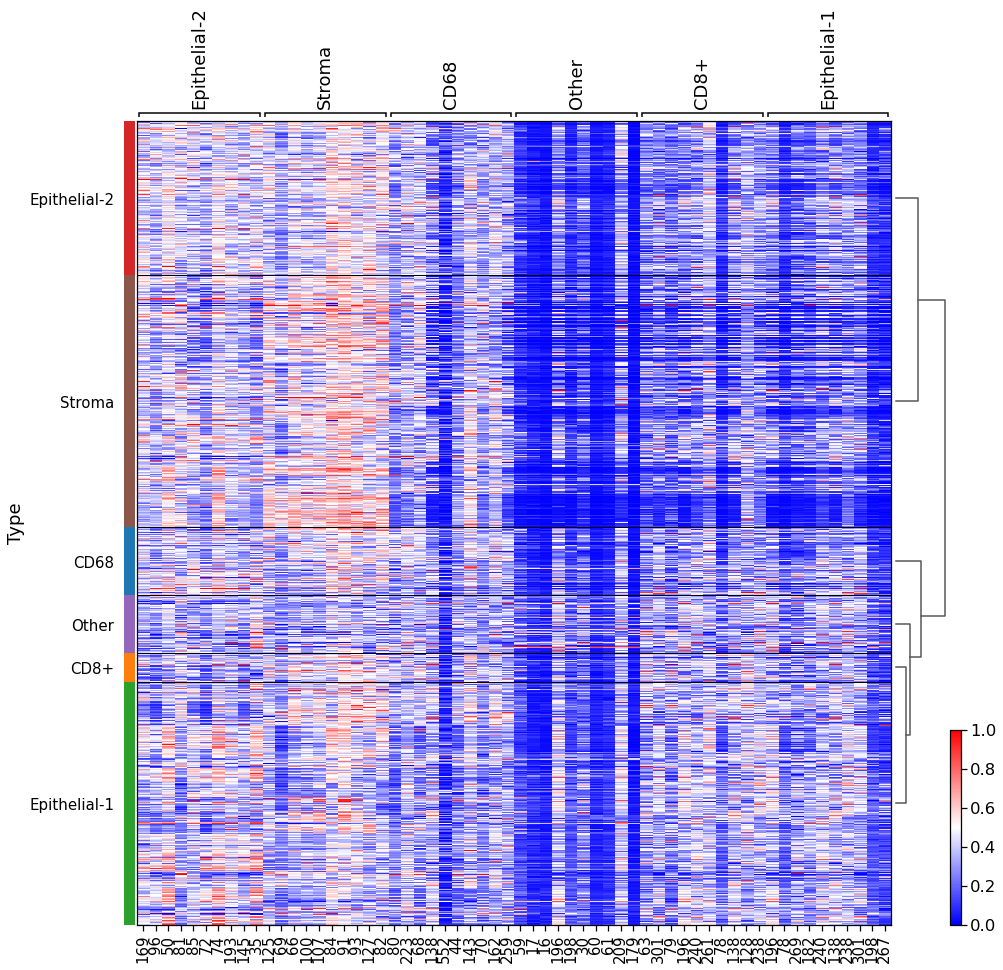

In [541]:
sns.set_context("notebook", font_scale=1.5)

dp_object =  sc.pl.rank_genes_groups_heatmap(adata_SIMS, groupby='Type', standard_scale='var', cmap='bwr', dendrogram=True, figsize=(15, 15), show_gene_labels=True)

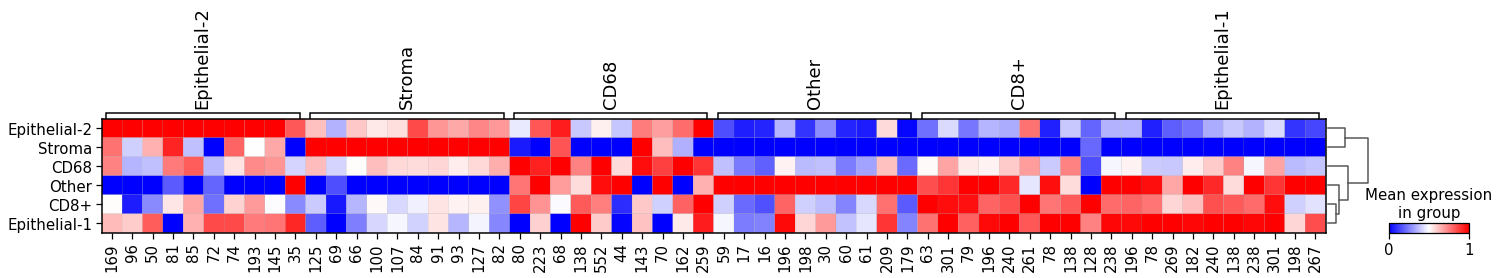

In [543]:
sns.set_context("notebook", font_scale=1.5)

sc.pl.rank_genes_groups_matrixplot(adata_SIMS, groupby='Type', standard_scale='var', cmap='bwr',dendrogram=True)


# Metabolites intensity bar plot

In [544]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()


In [553]:
df_genes = sc.get.rank_genes_groups_df(adata_SIMS, group='Epithelial-1').head(10)
channels = df_genes.names.tolist()

In [554]:
channels

['196', '78', '269', '182', '240', '138', '238', '301', '198', '267']

In [555]:
adata_epi = adata_SIMS[:, channels]
df = pd.DataFrame(adata_epi.X, columns=adata_epi.var_names)
x_scaled = min_max_scaler.fit_transform(df.values)
df = pd.DataFrame(x_scaled, columns=df.columns)
df['Type'] = adata_epi.obs.Type.tolist()


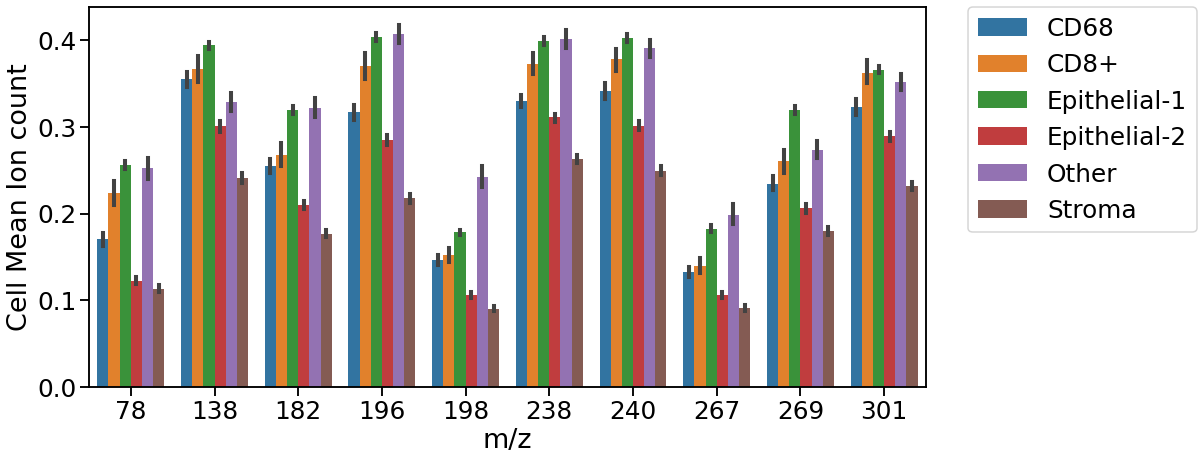

In [556]:
sns.set_context("talk", font_scale=1.5)

# Cell region mean intensity
df_subset = df.melt(id_vars=['Type', ], var_name='m/z', value_name='Intensity')
df_subset['m/z'] = df_subset['m/z'].astype(int)
df_subset.sort_values('m/z')
df_subset.head()

hue_plot_params = {
    'data':      df_subset,
    'x':         'm/z',
    'y':         'Intensity',
    "hue":       "Type",
    "hue_order": adata_SIMS.obs.Type.cat.categories.tolist(),
    "palette":   sns.color_palette(adata_IMC.uns["Type_colors"])
}

# Plot
fig, ax = plt.subplots(figsize=(15, 7))
ax = sns.barplot(**hue_plot_params)
ax.set_ylabel("Cell Mean Ion count")
# ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)